# Skip-gram Implementation Project

Welcome to my skip gram notebook! Here, we'll uncover the mystery behind word embeddings by building a skip-gram model from scratch and see why such a simple model can create such interesting results!

## Introduction to Skip-gram

The  Skip-Gram  model  introduced  an  efficient  and  intuitive  way  to  create  word embeddings  with  various  positive  qualities.  With this model you could find so many common relationships between words, just by considering the context words appear in. The context in this case, is simply whatever words are nearby in the text you use for training. 
<br><br>
The model chooses to represet words as vectors that live in a high-dimensional space. These vectors are trained to be close to eachother if they typically appear in the same context, and far apart if they typically don't. This basically means they are a bunch of points, and the ones that are near to each other should be related words while the ones that are far apart should be unrelated.
<br><br>
Of course, the proper context for a given word must be learned in practice, such as in the transformer model, but the skip-gram model layed a smooth foundation for the expedited progress of natural language processing in the past 10 years.

## Project Goals

In this project, our main goals are:

1. **Understanding Skip-gram:** We will start by grasping the architecture of the skip-gram model along with it's training objective. This will teach us how important a good training objective is, and how it can create such fascinating results.

2. **Data Preprocessing:** Before diving into the model implementation, we will prepare our data. This step involves cleaning and organizing the text data to ensure it's meets the training objective.

3. **Model Implementation:** We'll build the architecture as efficiently as we can, covering the output weights and the embeddings.

4. **Forward and Backward Passes:** With the model implemented, we'll train it using our processed dataset and evaluate its performance. We will learn together how training happens in this model, and how gradients are propagated!

5. **Visualization:** To gain insights into the model's output, we'll visualize the word embeddings in a lower-dimensional space. We will also measure the predicted distribution across all words and see how it changes over time.

6. **Discussion:** Lastly, we'll discuss the efficiency concerns of the model, and the limitations in training both in this way, and on such a limited dataset. 


## Understanding Skip-gram
***
The skip-gram model takes in an emedding matrix, passes it through one layer and compares it to a target (the context). The embedding matrix is essentially all the word vectors we have, one per word, and we will select the current word vector based on the current word in the text. 
<br><br> The context is also a vector. It is has one value per word, and this value is 0 if the word is not in the context and 1 if it is.

So if I had: 
- "It is nice outside today" and current word is "nice" 
- $\rightarrow$ Get the word vector for "nice" from the embedding matrix
- $\rightarrow$ Pass it through the skip-gram model
- $\rightarrow$ Get output vector with values between (0, 1). 0 means not in context and 1 means in context.
- $\rightarrow$ Compare to ground truth (context) which has a 1 exactly where the surrounding words "It" "is" "outside" "today" are, and 0 everywhere else.

## Data Loading and Preprocessing 
***
So, before I get ahead of myself, let's prepare the data. Here, we want to read in a corpus (text file). Ideally, this will be prepared with care so as to encourage good relationships by the model. In my case, since this is a refactor of my first implementation of this project, and GPT has since come out.......I'll ask it to give me a corpus that propotes semantically meaningful embeddings. I don't really know how its figuring that out, but if you're interested, I'll show a bit of it below.

1. First we read the file line by line. 
2. Then we will process the data to remove punctuation, stopwords and split into words.
    - We can use re to effeciently clean the punctuation and numbers from our text.
    - NLTK provides a nice collection of stopwords we can install, so we use those to get rid of our stopwords.
3. Lastly, we create our encoding, which maps our words to indices in our embedding matrix, so we can quickly choose the current word in the training process.

In [1]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

def get_data(filename):
    contents = []
    with open(filename, 'r') as f:
        lines = f.read()
    
    return lines

def process_data(text):
    stop_words = set(stopwords.words('english'))

    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    
    cleaned_text = text.strip()

    words = cleaned_text.split(' ')
    stop_words_removed = [word.lower() for word in words if word.lower() not in stop_words]

    return stop_words_removed

def display_text(text, words=None):
    print('-'*6 + f'\nCORPUS\n' + '-'*6)
    for i, line in enumerate(corpus.split('.')):
        print(line)

        if i > 5:
            break

    if words is not None:
        print()
        print('-'*5 + f'\nWORDS\n' + '-'*5)
        print(words[:10])

[nltk_data] Downloading package stopwords to
[nltk_data]     /mnt/c/Users/chris/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
DATA_DIR = '../../data/'
FILE = 'corpus.txt'

filename = DATA_DIR + FILE

corpus = get_data(filename)
words = process_data(corpus)

Here you can see some of the original corpus, versus our list of words after preprocessing our data for training. We remove all punctuation, and filter out the stopwords. It's a fairly basic preprocessing stage, but good enough for the purposes of this project.

In [3]:
display_text(corpus, words)

------
CORPUS
------
In the heart of the bustling city, travelers gather to share stories of their adventures
 Each journey brings unique experiences and lessons, as explorers venture into uncharted territories


High in the mountains, where the air is crisp and the landscapes breathtaking, hikers navigate winding trails, uncovering hidden gems amidst the wilderness
 The echo of footsteps resonates through the valleys, connecting those who seek solace in nature


Along the coastline, waves kiss the shore, leaving behind a treasure trove of shells and secrets
 Sailors set sail on the vast sea, chasing the horizon with dreams of distant lands
 The ocean's expanse reflects the infinite possibilities of the world

-----
WORDS
-----
['heart', 'bustling', 'city', 'travelers', 'gather', 'share', 'stories', 'adventures', 'journey', 'brings']


Now I will create an encoding for the words, so each word gets a unique index. Then I will create our embedding matrix as a randomly initialized matrix, with one vector for each word.
- I mentioned we are using a high-dimensional vector for each word. 
- This dimensionality can be modified, as a hyper-parameter it's important to see how the dimensionality affects our performance!

In [4]:
EMBEDDING_DIM = 64

In [5]:
# Tokenizer class is very simple, just getting the encodings for the words and maintaining the vocabulary
class Tokenizer():
    def __init__(self):
        self.vocab = []
        self.index_to_key = {}
        self.key_to_index = {}
    
    def fit(self, words):
        # get unique words
        vocab = set(words)
        # get index for each unique word and create forward and backward map
        self.index_to_key = {i : word for i, word in enumerate(vocab)}
        self.key_to_index = {word : i for i, word in enumerate(vocab)}
        self.vocab = list(vocab)

def encode_words(words, tokenizer):
    # encode the words as their indices for training
    encoding = [tokenizer.key_to_index[word] for word in words]

    return encoding


In [6]:
tokenizer = Tokenizer()
tokenizer.fit(words)
encoding = encode_words(words, tokenizer)

print('--------------'+'\nENCODED WORDS\n'+'--------------')
print('Words:', words[:10])
print('Encoding:', encoding[:10])

--------------
ENCODED WORDS
--------------
Words: ['heart', 'bustling', 'city', 'travelers', 'gather', 'share', 'stories', 'adventures', 'journey', 'brings']
Encoding: [125, 104, 112, 67, 158, 137, 86, 26, 168, 47]


In [7]:
tokenizer.index_to_key[:10]

TypeError: unhashable type: 'slice'

For our training set, we need a specific format. On each iteration, we will take the current word as input, and try to predict the surrounding words as output. So our training data has one input (the current word index) and one output (the surrounding words). The surrounding words are within a "window" of our input. This "window size" is also a hyper-parameter and can be adjusted.<br><br>
**Note:** The window size is the value of words we take in either direction, so the context is 2x the size.

In [ ]:
WINDOW_SIZE = 2

In [ ]:
import numpy as np

def one_hot(context_id, vocab_size):
    one_hot_vector = np.zeros(vocab_size)
    one_hot_vector[context_id] = 1.0
    
    return one_hot_vector

def create_dataset(encoding, tokenizer):
    dataset = []
    for i in range(len(encoding)):
        start = max(0, i - WINDOW_SIZE)
        end = min(len(encoding), i + WINDOW_SIZE + 1)

        context = encoding[start:i]
        context.extend(encoding[i+1:end])

        # target = one_hot(context, tokenizer)
        
        dataset.append({
            'input_id': encoding[i], 
            'context': [one_hot(context_id, len(tokenizer.vocab)) for context_id in context]
        })

    return dataset

In [ ]:
dataset = create_dataset(encoding, tokenizer)
dataset[0]

{'input_id': 77,
 'context': [array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 

## Embeddings and Model Architecutre
***
The model architecture is basically one weight matrix. This matrix has the dimensions (embedding_dim, vocab_size), and is often refered to as the output word vectors. This is because the output vectors which refer to each word in the context move closer together, providing their own relationships. Besides this we have our word embeddings. This will be a matrix of dimensions (vocab_size, embedding_dim), where each word in the vocab has its own vector of size (, embedding_dim).

#### SkipGramModel
- This class will hold the relevant parameters that the model should update during training. This will contain our word vectors and our weights. We also add fields for our callbacks, which store relevant information for later visualizations. 
    - The cool thing about saving the vectors as the model trains, is that we can visibly see them move toward "related" words.


In [ ]:
class SkipGramModel():
    def __init__(self, vocab_size, embedding_dim):
        # self.embedding_matrix = glorot_initialization((vocab_size, embedding_dim))
        # self.weights = glorot_initialization((embedding_dim, vocab_size))

        self.embedding_matrix = np.random.uniform(-1, 1, (vocab_size, embedding_dim))
        self.weights = np.random.uniform(-1, 1, (embedding_dim, vocab_size))

        self.vectors_over_time = []
        self.predictions_over_time = []
        self.loss_curve = []
    
    @staticmethod
    def softmax(score):
        exp_scores = np.exp(score - np.max(score))
        return exp_scores / exp_scores.sum()

    @staticmethod
    def glorot_initialization(shape):
        # Calculate the limit for uniform distribution
        limit = np.sqrt(6.0 / (shape[0] + shape[1]))
        
        # Initialize the matrix with values drawn from a uniform distribution
        embedding_matrix = np.random.uniform(-limit, limit, shape)
        return embedding_matrix
    
    def loss_fn(self, y_pred, context):
        epsilon = 1e-8
        # loss = -np.log(np.maximum(y_pred[context == 1], epsilon)).sum()
        loss = -np.sum(context * np.log(np.maximum(y_pred, epsilon)))

        return loss
    
    # for predictions, we perform an inner product with the weights, then softmax the score to get a distribution we compare to ground truth context
    def predict(self, input_id):
        try:    
            score = np.dot(self.embedding_matrix[input_id], self.weights)
            y_pred = softmax(score)
        except:
            print(input_id)
            y_pred = np.zeros(self.embedding_matrix.shape)
       

        return y_pred

    # backward pass transfers the gradient from the prediction error (y_pred - context)
    # to the weights by performing an outer product with the current word embedding. 
    # this is then used to update the embedding vector by performing an inner product on the new weights with the error
    def backward(self, input_id, context, y_pred):
        for context_vector in context:
            # Calculate the error as the difference between the prediction and the true context word
            error = y_pred - context_vector
            
            # Update the output vectors (model weights)
            self.weights -= LR * np.outer(self.embedding_matrix[input_id], error)

            # Update the input vectors (embedding vector)
            self.embedding_matrix[input_id] -= LR * np.dot(self.weights, error)



    def update_model_states(self, word_vectors_2d, predictions, loss):
        self.vectors_over_time.append(word_vectors_2d)
        self.predictions_over_time.append(predictions)
        self.loss_curve.append(loss)
        

In [ ]:
from sklearn.decomposition import PCA, TruncatedSVD

EPOCHS = 300
LR = 0.01

target_id = tokenizer.key_to_index['treasure']

def train(model, training_data, target_id=target_id):
    for epoch in range(EPOCHS):
        for sample in dataset:
            input_id = sample['input_id']
            context = np.array(sample['context'])
            
            y_pred = model.predict(input_id)
            loss = model.loss_fn(y_pred, context)

            model.backward(input_id, context, y_pred)
            # break

        if epoch % 10 == 0:
            x = TruncatedSVD().fit_transform(model.embedding_matrix)
            model.update_model_states(
                word_vectors_2d=x, 
                predictions=model.predict(target_id), 
                loss=loss)
        if epoch % 20 == 0:
            print(f"Epoch: {epoch} - Loss: {loss}")

In [ ]:
model = SkipGramModel(
    vocab_size=len(tokenizer.vocab), 
    embedding_dim=EMBEDDING_DIM
)

train(model, training_data=dataset)

Epoch: 0 - Loss: 16.372449921040957
Epoch: 20 - Loss: 3.022540583202623
Epoch: 40 - Loss: 1.6710076915382057
Epoch: 60 - Loss: 1.527006191308847
Epoch: 80 - Loss: 1.478385770786645
Epoch: 100 - Loss: 1.4546203831986713
Epoch: 120 - Loss: 1.440686469387813
Epoch: 140 - Loss: 1.4315856665960984
Epoch: 160 - Loss: 1.4252012838690182
Epoch: 180 - Loss: 1.42048929241608
Epoch: 200 - Loss: 1.4168773023426937
Epoch: 220 - Loss: 1.4140260848073443
Epoch: 240 - Loss: 1.411722196237712
Epoch: 260 - Loss: 1.4098248084285432
Epoch: 280 - Loss: 1.4082373474573793


In [ ]:
def cosine_similarity(vector1, vector2):
    dot_product = np.dot(vector1, vector2)
    norm_vector1 = np.linalg.norm(vector1)
    norm_vector2 = np.linalg.norm(vector2)
    similarity = dot_product / (norm_vector1 * norm_vector2)
    return similarity

# Assuming you have a list of words and their corresponding embedding vectors
embedding_matrix = model.embedding_matrix  # Your embedding matrix

# Get the embedding vector of the target word
target = embedding_matrix[target_id]

# Calculate cosine similarity between the target word and all other words
similarities = {}
for index in tokenizer.index_to_key:
    if index != target_id:
        similarity = cosine_similarity(target, embedding_matrix[index])
        similarities[tokenizer.index_to_key[index]] = similarity

# Sort the similar words by their cosine similarity
similar_words = sorted(similarities.items(), key=lambda x: x[1], reverse=True)

# Print the top similar words
print("Similar words for", tokenizer.index_to_key[target_id])
for word, similarity in similar_words[:5]:
    print(word, ":", similarity)


NameError: name 'model' is not defined

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def generate_unique_colors(num_colors):
    cmap = plt.get_cmap('tab20')
    return cmap(np.linspace(0, 1, num_colors))

def visualize_vectors_over_time(vectors_over_time, index_to_key, num_words=20, min_val=-5, max_val=5):
    # Only select vectors for the first num_words words
    vectors_over_time = [vectors[:num_words] for vectors in vectors_over_time]

    # Generate unique colors for each word
    num_colors = num_words
    unique_colors = generate_unique_colors(num_colors)

    # Create a figure and axis
    fig, ax = plt.subplots()
    sc = ax.scatter([], [])  # Initialize scatter plot with unique colors

    # Set the axis limits
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)

    # Create a list to hold the annotations
    annotations = [ax.annotate('', (0, 0)) for _ in range(num_words)]

    def update(frame):
        # Update the scatter plot data for each frame
        sc.set_offsets(vectors_over_time[frame])
        sc.set_color(unique_colors[:len(vectors_over_time[frame])])  # Set colors
        
        # Update annotations with word labels
        for i, (x, y) in enumerate(vectors_over_time[frame]):
            annotations[i].set_text(index_to_key[i])  # Set word label
            annotations[i].set_position((x, y))  # Set position
            annotations[i].set_visible(True)  # Make annotation visible

        return sc, *annotations

    # Create the animation
    ani = FuncAnimation(fig, update, frames=len(vectors_over_time), blit=True)
    return ani


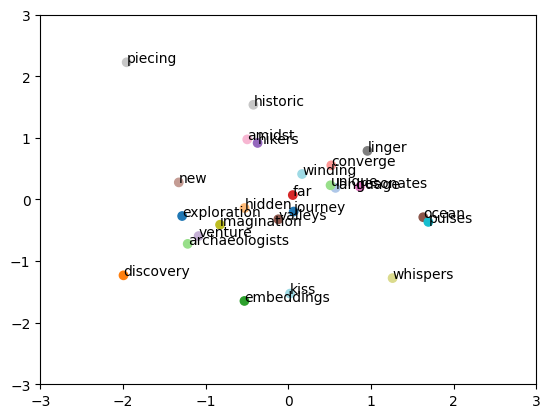

In [ ]:
ani = visualize_vectors_over_time(model.vectors_over_time, tokenizer.index_to_key, num_words=25, min_val=-3, max_val=3)
plt.plot(model.loss_curve)

In [ ]:
# Display the animation
HTML(ani.to_jshtml())

In [ ]:
def visualize_predictions_over_time(pred_over_time, y_true, index_to_key, num_words=20, epochs=100):
    # Create a figure and axis
    fig, ax = plt.subplots()
    lines, = ax.plot([], [], color='red', label='Predicted')  # Note the comma after 'lines'
    ground_truth_line, = ax.plot(y_true, color='green', label='Ground Truth')

    # Set the axis limits
    ax.set_xlim(0, len(index_to_key))
    ax.set_ylim(0, 1)  # Assuming context probabilities are between 0 and 1
    
    # Set labels and legend
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Probability')
    ax.legend(loc='upper right')

    # Create a list to hold the annotations
    annotations = [ax.annotate('', (0, 0)) for _ in range(num_words)]

    def update(frame):
        prob_list = pred_over_time[frame]
        lines.set_data(range(len(prob_list)), prob_list)

        # Update annotations with word labels
        # for i, prob in enumerate(prob_list):
        #     annotations[i].set_text(index_to_key[i])  # Set word label
        #     annotations[i].set_position((i, prob))  # Set position

        return lines, *annotations

    # Create the animation
    ani = FuncAnimation(fig, update, frames=len(pred_over_time), blit=True)
    return ani


In [ ]:
def get_context_distribution(dataset, input_id, vocab_size):
    context_accumulator = np.zeros(vocab_size)

    # Iterate through the corpus data
    for sample in dataset:
        if sample['input_id'] == input_id:
            context_accumulator += np.sum(sample['context'], axis=0)

    # Calculate the distribution by normalizing the accumulator
    context_distribution = context_accumulator / context_accumulator.sum()

    return context_distribution

y_true = get_context_distribution(dataset, target_id, len(tokenizer.vocab))


[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.25 0.   0.25 0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.25 0.   0.   0.   0.   0.   0.   0.   0.25
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.  ]


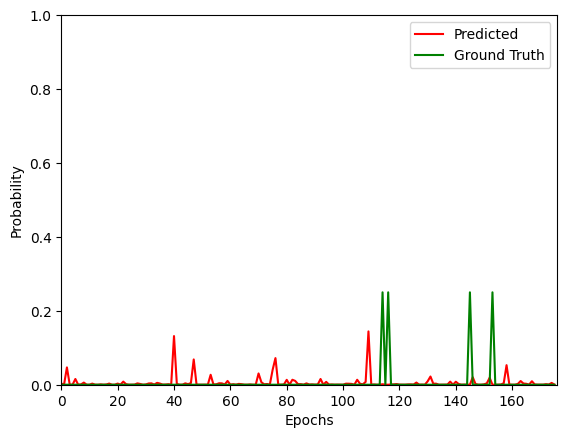

In [ ]:
ani2 = visualize_predictions_over_time(preds, y_true, tokenizer.index_to_key)

In [ ]:
# Display the animation
HTML(ani2.to_jshtml())